# Lab 17: Ordinary Differential Equations - Boundary Value Problems

This notebook demonstrates fundamental numerical methods for solving boundary value problems, where conditions are specified at multiple points (boundaries) rather than all at one initial point.

**Methods Covered:**
1. **Shooting Method** - Convert BVP to IVP
2. **Finite Difference Method** - Discretize the domain
3. **Relaxation Method** - Iterative solution for 2D problems

**Applications:**
- Beam deflection
- Wave motion and vibrations
- Heat conduction (steady-state)

In [2]:
#import required packages
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
from scipy.optimize import fsolve, root_scalar
from scipy.sparse import diags
from scipy.sparse.linalg import spsolve

# Set plotting style to improve figures
plt.style.use('seaborn-v0_8-darkgrid')
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 11

## 1. Methods

### 1.1 Shooting Method

The shooting method converts a BVP into an IVP by:
1. Guessing the unknown initial condition(s)
2. Solving the resulting IVP
3. Checking if the solution satisfies the boundary condition at the other end
4. Adjusting the guess and repeating until convergence

**For a second-order BVP:**
$$y'' = f(x, y, y'), \quad y(a) = \alpha, \quad y(b) = \beta$$

We guess $y'(a) = s$ (the "shooting angle"), solve the IVP, and find $s$ such that $y(b) = \beta$.

**Advantages:**
- Can use standard IVP solvers (RK4, etc.)
- Works well for smooth problems
- Natural for problems with physical interpretation

**Disadvantages:**
- Can be sensitive to initial guess
- May fail for stiff problems
- Requires root-finding (adds complexity)

In [3]:
def shooting_method(f, x_span, ya, yb, s_guess=0.0, method='RK45'):
    """
    Solve a two-point BVP using the shooting method.
    
    For y'' = f(x, y, y') with y(x_span[0]) = ya and y(x_span[1]) = yb
    
    Parameters:
    -----------
    f : callable
        Function f(x, y, yp) defining y'' = f(x, y, y')
    x_span : tuple
        (x_start, x_end)
    ya : float
        Boundary condition at x_start
    yb : float
        Boundary condition at x_end
    s_guess : float
        Initial guess for y'(x_start)
    method : str
        Integration method for solve_ivp
    
    Returns:
    --------
    x : ndarray
        Solution points
    y : ndarray
        Solution values
    s : float
        The shooting parameter (initial slope)
    """
    
    def ode_system(x, Y):
        """Convert 2nd order ODE to system of 1st order ODEs"""
        y, yp = Y
        return [yp, f(x, y, yp)]
    
    def residual(s):
        """Solve IVP with initial slope s and return error at right boundary"""
        # Ensure s is a scalar (fsolve may pass it as array)
        s_val = float(s) if np.isscalar(s) else float(s[0])
        sol = solve_ivp(ode_system, x_span, [ya, s_val], method=method, dense_output=True)
        return sol.y[0, -1] - yb
    
    # Find the correct shooting parameter
    result = fsolve(residual, [s_guess], full_output=True)
    s_optimal = float(result[0][0])
    
    # Solve with optimal shooting parameter
    sol = solve_ivp(ode_system, x_span, [ya, s_optimal], method=method, dense_output=True)
    
    return sol.t, sol.y[0], s_optimal

### 1.2 Finite Difference Method

The finite difference method discretizes the domain into a grid and approximates derivatives using difference formulas.

**Derivative Approximations:**

$$y'(x_i) \approx \frac{y_{i+1} - y_{i-1}}{2h} \quad \text{(central difference)}$$

$$y''(x_i) \approx \frac{y_{i+1} - 2y_i + y_{i-1}}{h^2}$$

For the BVP: $y'' = f(x, y, y')$ with $y(a) = \alpha$, $y(b) = \beta$

We get a system of algebraic equations:
$$\frac{y_{i+1} - 2y_i + y_{i-1}}{h^2} = f(x_i, y_i, \frac{y_{i+1} - y_{i-1}}{2h})$$

**Advantages:**
- Stable and robust
- Easy to implement boundary conditions
- Works well for linear and many nonlinear problems
- Natural for problems on fixed domains

**Disadvantages:**
- Requires solving system of equations (can be large)
- Accuracy depends on grid spacing
- Nonlinear problems require iterative solution

In [4]:
def finite_difference_linear(p, q, r, x_span, ya, yb, n=100):
    """
    Solve linear BVP using finite difference method.
    
    For y'' + p(x)y' + q(x)y = r(x) with y(a) = ya, y(b) = yb
    
    Parameters:
    -----------
    p, q, r : callable
        Coefficient functions
    x_span : tuple
        (a, b) domain boundaries
    ya, yb : float
        Boundary values
    n : int
        Number of interior points
    
    Returns:
    --------
    x : ndarray
        Grid points
    y : ndarray
        Solution values
    """
    a, b = x_span
    h = (b - a) / (n + 1)
    x = np.linspace(a, b, n + 2)
    
    # Build the coefficient matrix (tridiagonal)
    # y''_i ≈ (y_{i+1} - 2y_i + y_{i-1})/h^2
    # y'_i ≈ (y_{i+1} - y_{i-1})/(2h)
    
    # Interior points: i = 1, 2, ..., n
    main_diag = np.zeros(n)
    upper_diag = np.zeros(n-1)
    lower_diag = np.zeros(n-1)
    rhs = np.zeros(n)
    
    for i in range(n):
        xi = x[i+1]  # Interior point
        
        # Coefficients from finite difference approximation
        # (1/h^2 - p_i/(2h))y_{i-1} + (-2/h^2 + q_i)y_i + (1/h^2 + p_i/(2h))y_{i+1} = r_i
        
        pi = p(xi)
        qi = q(xi)
        ri = r(xi)
        
        main_diag[i] = -2/h**2 + qi
        
        if i > 0:
            lower_diag[i-1] = 1/h**2 - pi/(2*h)
        if i < n-1:
            upper_diag[i] = 1/h**2 + pi/(2*h)
        
        rhs[i] = ri
        
        # Incorporate boundary conditions
        if i == 0:
            rhs[i] -= ya * (1/h**2 - pi/(2*h))
        if i == n-1:
            rhs[i] -= yb * (1/h**2 + pi/(2*h))
    
    # Solve the tridiagonal system
    A = diags([lower_diag, main_diag, upper_diag], [-1, 0, 1], format='csr')
    y_interior = spsolve(A, rhs)
    
    # Combine with boundary values
    y = np.concatenate([[ya], y_interior, [yb]])
    
    return x, y


def finite_difference_nonlinear(f, x_span, ya, yb, n=100, max_iter=50, tol=1e-8):
    """
    Solve nonlinear BVP using finite difference method with Newton's method.
    
    For y'' = f(x, y, y') with y(a) = ya, y(b) = yb
    
    Parameters:
    -----------
    f : callable
        Function f(x, y, yp) defining y'' = f(x, y, y')
    x_span : tuple
        (a, b) domain boundaries
    ya, yb : float
        Boundary values
    n : int
        Number of interior points
    
    Returns:
    --------
    x : ndarray
        Grid points
    y : ndarray
        Solution values
    """
    a, b = x_span
    h = (b - a) / (n + 1)
    x = np.linspace(a, b, n + 2)
    
    def residual(y_interior):
        """Compute residual for Newton's method"""
        y = np.concatenate([[ya], y_interior, [yb]])
        res = np.zeros(n)
        
        for i in range(n):
            xi = x[i+1]
            yi = y[i+1]
            yp = (y[i+2] - y[i]) / (2*h)
            ypp = (y[i+2] - 2*y[i+1] + y[i]) / h**2
            
            res[i] = ypp - f(xi, yi, yp)
        
        return res
    
    # Initial guess (linear interpolation)
    y_interior_init = ya + (yb - ya) * (x[1:-1] - a) / (b - a)
    
    # Solve using Newton's method
    y_interior = fsolve(residual, y_interior_init)
    
    y = np.concatenate([[ya], y_interior, [yb]])
    
    return x, y

---
## 2. Examples

Now let's apply these methods to a few example problems!

### 2.1 Beam Deflection Under Load

#### **Problem Statement**

A beam of length $L$ is simply supported at both ends and subjected to a uniform load $w$. Find the deflection $y(x)$ of the beam.

**Governing Equation (Euler-Bernoulli Beam Theory):**
$$EI\frac{d^4y}{dx^4} = w(x)$$

For uniform load $w$:
$$\frac{d^4y}{dx^4} = \frac{w}{EI}$$

**Boundary Conditions (Simply Supported):**
$$y(0) = 0, \quad y''(0) = 0, \quad y(L) = 0, \quad y''(L) = 0$$

For a second-order formulation, let $\theta = y'$ (slope) and $M = EI y''$ (moment):
$$\frac{d^2M}{dx^2} = w$$

**Analytical Solution:**
$$y(x) = \frac{w}{24EI}x(L^3 - 2Lx^2 + x^3)$$

Start by setting up the system and parameters in the cell below

In [5]:
# Parameters
L = 10.0  # Length (m)
E = 200e9  # Young's modulus (Pa) - steel
I = 1e-4  # Second moment of area (m^4)
w = 1000.0  # Uniform load (N/m)

# Define ODE: y'''' = w/(EI)
# Convert to 2nd order: M'' = w, where M = EI*y''
def beam_equation(x, M, Mp):
    return w

Perform the finite difference calculation

In [6]:
print("Solving moment equation with finite difference...")
x_fd, M_fd = finite_difference_linear(
    lambda x: 0,
    lambda x: 0,
    lambda x: w,
    (0, L), 0.0, 0.0, n=100
)

# Convert moment to deflection: y = integral(integral(M/(EI)))
# Numerical integration
theta_fd = np.zeros_like(M_fd)
y_fd = np.zeros_like(M_fd)

dx = x_fd[1] - x_fd[0]
for i in range(1, len(x_fd)):
    theta_fd[i] = theta_fd[i-1] + M_fd[i-1] / (E * I) * dx
    y_fd[i] = y_fd[i-1] + theta_fd[i-1] * dx

# Apply boundary conditions: y(0) = 0 and y(L) = 0
# The integration gives y(0) = 0 automatically, but y(L) may not be zero
# Subtract a linear correction to enforce y(L) = 0
y_fd = y_fd - (x_fd / L) * y_fd[-1]

print("Done")

Solving moment equation with finite difference...
Done


Now define the analytic solution

In [7]:
# Analytical solution
def y_exact_beam(x):
    return (w / (24 * E * I)) * x * (L**3 - 2*L*x**2 + x**3)

x_exact = np.linspace(0, L, 200)
y_exact_vals = y_exact_beam(x_exact)

Plot the results

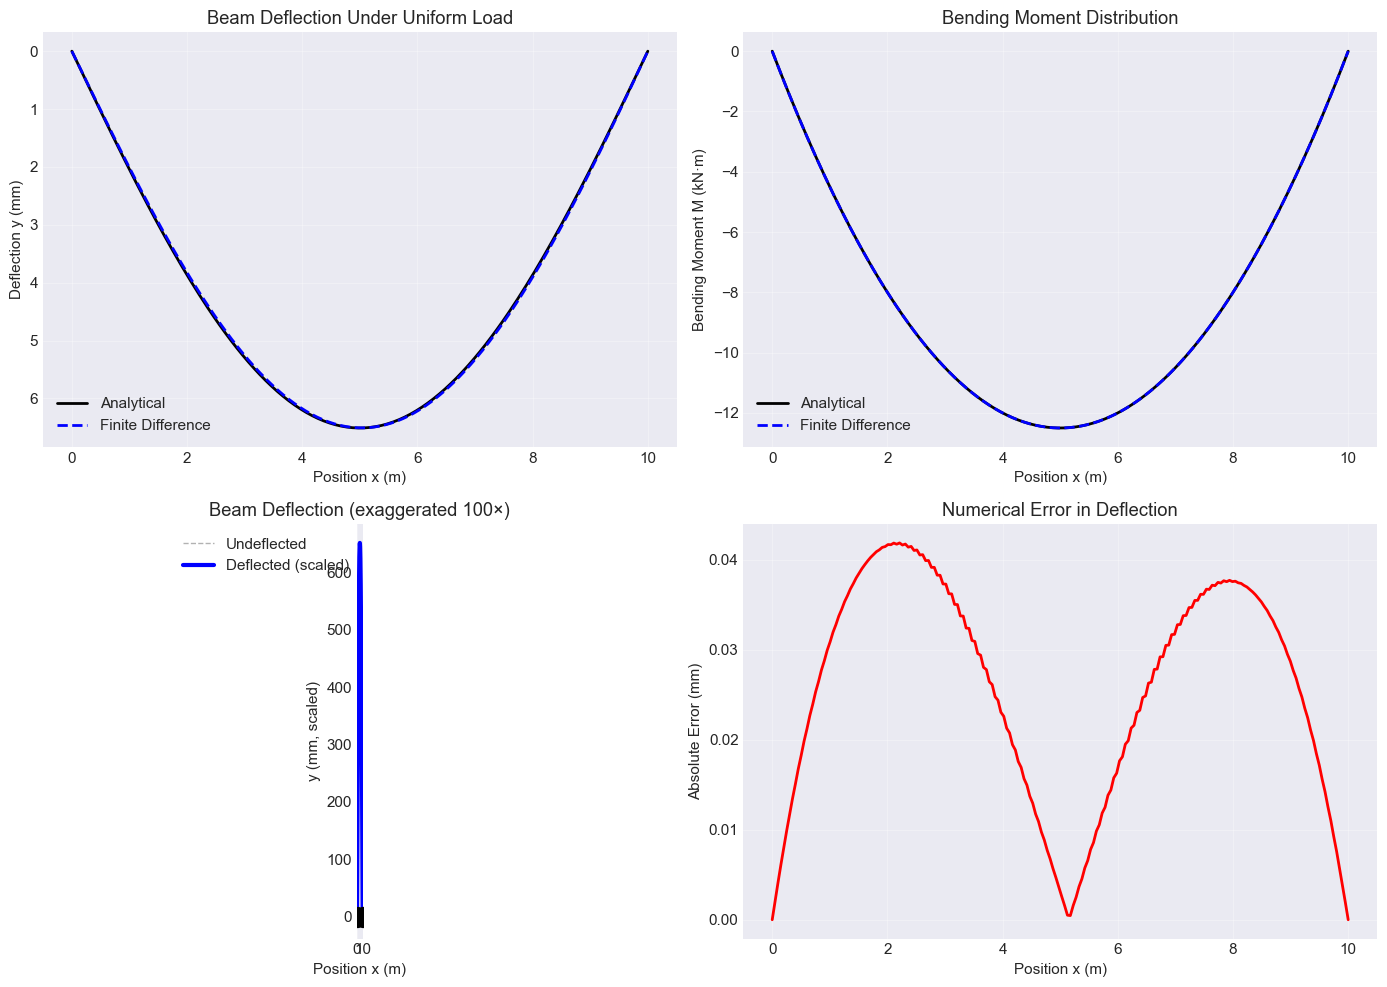

In [8]:
# Plot beam deflection
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Deflection
axes[0, 0].plot(x_exact, y_exact_vals * 1000, 'k-', linewidth=2, label='Analytical')
axes[0, 0].plot(x_fd, y_fd * 1000, 'b--', linewidth=2, label='Finite Difference')
axes[0, 0].set_xlabel('Position x (m)')
axes[0, 0].set_ylabel('Deflection y (mm)')
axes[0, 0].set_title('Beam Deflection Under Uniform Load')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)
axes[0, 0].invert_yaxis()

# Moment diagram
M_exact = -w * x_exact * (L - x_exact) / 2
axes[0, 1].plot(x_exact, M_exact / 1000, 'k-', linewidth=2, label='Analytical')
axes[0, 1].plot(x_fd, M_fd / 1000, 'b--', linewidth=2, label='Finite Difference')
axes[0, 1].set_xlabel('Position x (m)')
axes[0, 1].set_ylabel('Bending Moment M (kN·m)')
axes[0, 1].set_title('Bending Moment Distribution')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

# Beam visualization
scale_factor = 100  # Exaggerate deflection for visualization
axes[1, 0].plot(x_exact, np.zeros_like(x_exact), 'k--', linewidth=1, alpha=0.3, label='Undeflected')
axes[1, 0].plot(x_exact, y_exact_vals * scale_factor * 1000, 'b-', linewidth=3, label='Deflected (scaled)')
axes[1, 0].plot([0, 0], [-5, 5], 'ko', markersize=10)
axes[1, 0].plot([L, L], [-5, 5], 'ko', markersize=10)
axes[1, 0].set_xlabel('Position x (m)')
axes[1, 0].set_ylabel('y (mm, scaled)')
axes[1, 0].set_title(f'Beam Deflection (exaggerated {scale_factor}×)')
axes[1, 0].legend()
axes[1, 0].set_aspect('equal')
axes[1, 0].grid(True, alpha=0.3)

# Error
y_fd_interp = np.interp(x_exact, x_fd, y_fd)
error_y = np.abs(y_fd_interp - y_exact_vals) * 1000
axes[1, 1].plot(x_exact, error_y, 'r-', linewidth=2)
axes[1, 1].set_xlabel('Position x (m)')
axes[1, 1].set_ylabel('Absolute Error (mm)')
axes[1, 1].set_title('Numerical Error in Deflection')
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

Determine the max deflection and the max error

In [9]:
max_deflection = np.min(y_exact_vals) * 1000
print(f"\nMaximum deflection: {abs(max_deflection):.3f} mm")
print(f"Maximum error: {np.max(error_y):.3e} mm")


Maximum deflection: 0.000 mm
Maximum error: 4.184e-02 mm


### 2.2 The Wave Equation - Vibrations on a String (Eigenvalue Problem)

#### **Problem Statement**

Find the natural frequencies and mode shapes of a vibrating string of length $L$ fixed at both ends.

**Governing Equation:**
$$\frac{\partial^2 u}{\partial t^2} = c^2 \frac{\partial^2 u}{\partial x^2}$$

Assuming harmonic motion $u(x,t) = y(x)e^{i\omega t}$:

$$\frac{d^2y}{dx^2} + k^2 y = 0$$

where $k^2 = \omega^2/c^2$.

**Boundary Conditions:**
$$y(0) = 0, \quad y(L) = 0$$

**Analytical Solution:**
$$y_n(x) = \sin\left(\frac{n\pi x}{L}\right), \quad k_n = \frac{n\pi}{L}, \quad n = 1, 2, 3, ...$$

$$f_n = \frac{c k_n}{2\pi} = \frac{nc}{2L}$$

Start by setting up the system and parameters in the cell below

In [10]:
# Parameters
L = 1.0  # String length (m)
c = 100.0  # Wave speed (m/s)

The function below converts the finite difference into an eigenvalue problem

In [11]:
# Note that y'' + k²y = 0 becomes a matrix eigenvalue problem

def find_modes_finite_difference(L, n_points=100, n_modes=5):
    """
    Find natural frequencies and mode shapes using finite difference.
    """
    h = L / (n_points + 1)
    x = np.linspace(0, L, n_points + 2)
    
    # Build the second derivative matrix
    # y''_i ≈ (y_{i+1} - 2y_i + y_{i-1})/h²
    main_diag = -2 * np.ones(n_points)
    off_diag = np.ones(n_points - 1)
    D2 = (1/h**2) * diags([off_diag, main_diag, off_diag], [-1, 0, 1], format='array')
    
    # Solve eigenvalue problem: D2 * y = -k² * y
    eigenvalues, eigenvectors = np.linalg.eig(D2)
    
    # Sort by eigenvalue magnitude
    idx = np.argsort(np.abs(eigenvalues))
    eigenvalues = eigenvalues[idx]
    eigenvectors = eigenvectors[:, idx]
    
    # Extract first n_modes
    k_squared = -eigenvalues[:n_modes]
    k_values = np.sqrt(np.abs(k_squared))
    
    # Mode shapes (include boundary points)
    modes = np.zeros((n_modes, n_points + 2))
    for i in range(n_modes):
        modes[i, 1:-1] = eigenvectors[:, i]
        # Normalize
        modes[i] = modes[i] / np.max(np.abs(modes[i]))
    
    return x, k_values, modes

Perform the finite difference calculation

In [12]:
print("Computing natural frequencies and mode shapes...")
x_modes, k_numerical, modes_numerical = find_modes_finite_difference(L, n_points=100, n_modes=5)
f_numerical = k_numerical * c / (2 * np.pi)
print("Done")

Computing natural frequencies and mode shapes...
Done


create the analytic solution

In [13]:
# Analytical frequencies
n_values = np.arange(1, 6)
k_analytical = n_values * np.pi / L
f_analytical = k_analytical * c / (2 * np.pi)

Plot and compare results

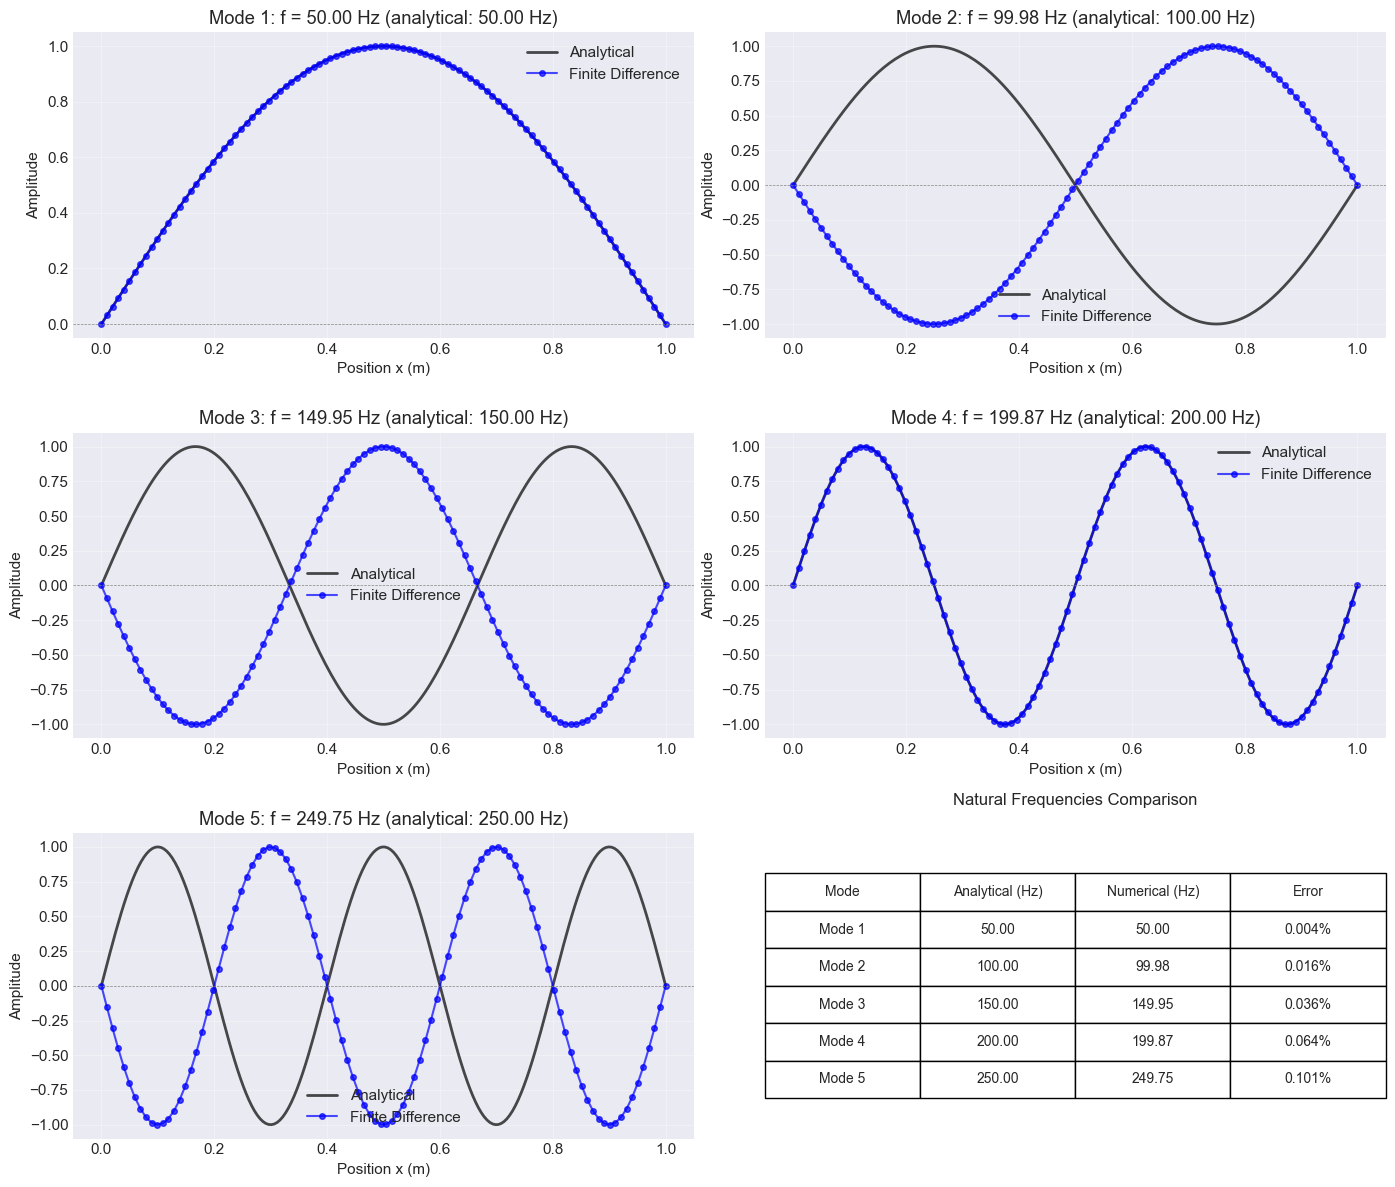

In [14]:
# Plot mode shapes
fig, axes = plt.subplots(3, 2, figsize=(14, 12))
axes = axes.flatten()

x_exact = np.linspace(0, L, 200)

for i in range(5):
    n = i + 1
    
    # Analytical mode shape
    y_analytical = np.sin(n * np.pi * x_exact / L)
    
    # Plot
    axes[i].plot(x_exact, y_analytical, 'k-', linewidth=2, label='Analytical', alpha=0.7)
    axes[i].plot(x_modes, modes_numerical[i], 'bo-', linewidth=1.5, 
                 markersize=4, label='Finite Difference', alpha=0.7)
    axes[i].axhline(0, color='gray', linestyle='--', linewidth=0.5)
    axes[i].set_xlabel('Position x (m)')
    axes[i].set_ylabel('Amplitude')
    axes[i].set_title(f'Mode {n}: f = {f_numerical[i]:.2f} Hz (analytical: {f_analytical[i]:.2f} Hz)')
    axes[i].legend()
    axes[i].grid(True, alpha=0.3)

# Summary table in the last subplot
axes[5].axis('off')
table_data = []
for i in range(5):
    error = abs(f_numerical[i] - f_analytical[i]) / f_analytical[i] * 100
    table_data.append([f'Mode {i+1}', f'{f_analytical[i]:.2f}', 
                       f'{f_numerical[i]:.2f}', f'{error:.3f}%'])

table = axes[5].table(cellText=table_data,
                      colLabels=['Mode', 'Analytical (Hz)', 'Numerical (Hz)', 'Error'],
                      cellLoc='center',
                      loc='center')
table.auto_set_font_size(False)
table.set_fontsize(10)
table.scale(1, 2)
axes[5].set_title('Natural Frequencies Comparison', fontsize=12, pad=20)

plt.tight_layout()
plt.show()

### 2.3 Steady-State Heat Conduction

#### **Problem Statement**

A metal rod of length $L$ has temperature $T_0$ at one end and $T_L$ at the other. Heat is generated uniformly throughout the rod at rate $q$. Find the steady-state temperature distribution.

**Governing Equation:**
$$\frac{d^2T}{dx^2} = -\frac{q}{k}$$

where $k$ is the thermal conductivity.

**Boundary Conditions:**
$$T(0) = T_0, \quad T(L) = T_L$$

**Analytical Solution:**
$$T(x) = T_0 + (T_L - T_0)\frac{x}{L} - \frac{q}{2k}x(L-x)$$

Start by setting up the system and parameters in the cell below

In [15]:
# Parameters
L = 1.0  # Length (m)
k = 50.0  # Thermal conductivity (W/m·K)
q = 1000.0  # Heat generation rate (W/m³)
T0 = 300.0  # Temperature at x=0 (K)
TL = 400.0  # Temperature at x=L (K)

# Define the ODE: T'' = -q/k
def heat_equation(x, T, Tp):
    return -q / k

Solve the ODE by calling our earlier defined methods

In [16]:
# Solve using shooting method
print("Solving with shooting method...")
x_shoot, T_shoot, slope = shooting_method(heat_equation, (0, L), T0, TL, s_guess=100)

# Solve using finite difference (as linear problem)
# T'' + 0*T' + 0*T = -q/k
print("Solving with finite difference method...")
x_fd, T_fd = finite_difference_linear(
    lambda x: 0,  # p(x)
    lambda x: 0,  # q(x)
    lambda x: -q/k,  # r(x)
    (0, L), T0, TL, n=50
)

print("Done")

Solving with shooting method...
Solving with finite difference method...
Done


Create the analytic solution for comparison

In [17]:
# Analytical solution
def T_exact(x):
    return T0 + (TL - T0) * x / L - (q / (2 * k)) * x * (L - x)

# create analytical solution
x_exact = np.linspace(0, L, 200)
T_exact_vals = T_exact(x_exact)

Plot the results

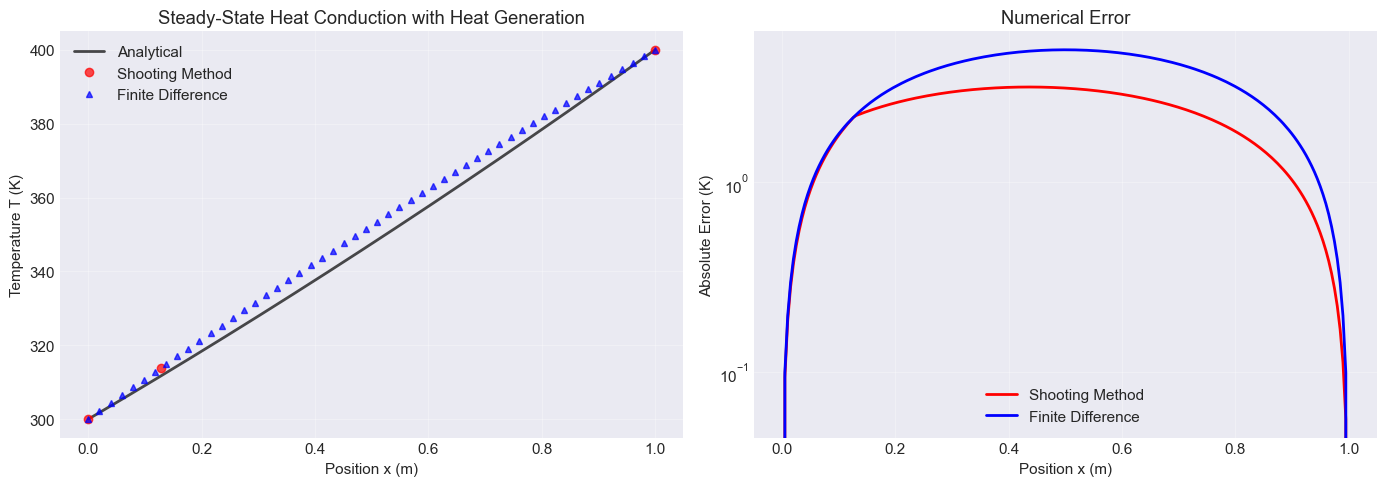

In [18]:
# Plot results
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# Temperature distribution
ax1.plot(x_exact, T_exact_vals, 'k-', linewidth=2, label='Analytical', alpha=0.7)
ax1.plot(x_shoot, T_shoot, 'ro', markersize=6, label='Shooting Method', alpha=0.7)
ax1.plot(x_fd, T_fd, 'b^', markersize=5, label='Finite Difference', alpha=0.7)
ax1.set_xlabel('Position x (m)')
ax1.set_ylabel('Temperature T (K)')
ax1.set_title('Steady-State Heat Conduction with Heat Generation')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Error comparison
T_shoot_interp = np.interp(x_exact, x_shoot, T_shoot)
T_fd_interp = np.interp(x_exact, x_fd, T_fd)

error_shoot = np.abs(T_shoot_interp - T_exact_vals)
error_fd = np.abs(T_fd_interp - T_exact_vals)

ax2.semilogy(x_exact, error_shoot, 'r-', linewidth=2, label='Shooting Method')
ax2.semilogy(x_exact, error_fd, 'b-', linewidth=2, label='Finite Difference')
ax2.set_xlabel('Position x (m)')
ax2.set_ylabel('Absolute Error (K)')
ax2.set_title('Numerical Error')
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

Determine the maximum error in both methods

In [19]:
print(f"\nMaximum errors:")
print(f"  Shooting Method: {np.max(error_shoot):.2e} K")
print(f"  Finite Difference: {np.max(error_fd):.2e} K")


Maximum errors:
  Shooting Method: 3.18e+00 K
  Finite Difference: 5.00e+00 K


### 2.4 Nonlinear BVP - Pendulum Deflection

#### **Problem Statement**

A heavy cable or chain hanging between two points forms a catenary. For large deflections, we need to solve the nonlinear equation:

**Governing Equation:**
$$\frac{d^2\theta}{dx^2} = -\frac{g}{L}\sin(\theta)$$

where $\theta$ is the angle from vertical, for a pendulum or hanging chain.

**Boundary Conditions:**
$$\theta(0) = \theta_0, \quad \theta(L) = \theta_L$$

This is a nonlinear BVP that doesn't have a simple analytical solution.

Start by setting up the system and parameters in the cell below

In [20]:
# Parameters
L_pend = 1.0  # Length
g = 9.81  # Gravity
theta0 = np.pi / 6  # 30 degrees at x=0
thetaL = -np.pi / 6  # -30 degrees at x=L

# Define nonlinear ODE
def pendulum_ode(x, theta, theta_p):
    return -(g / L_pend) * np.sin(theta)

Solve the ODE by calling our methods

In [21]:
print("Solving nonlinear pendulum BVP with shooting method...")
x_shoot_nl, theta_shoot, slope_nl = shooting_method(pendulum_ode, (0, L_pend), theta0, thetaL, s_guess=0.0)

print("Solving with finite difference method...")
x_fd_nl, theta_fd = finite_difference_nonlinear(pendulum_ode, (0, L_pend), theta0, thetaL, n=100)

print("Done")

Solving nonlinear pendulum BVP with shooting method...
Solving with finite difference method...
Done


Plot and compare results

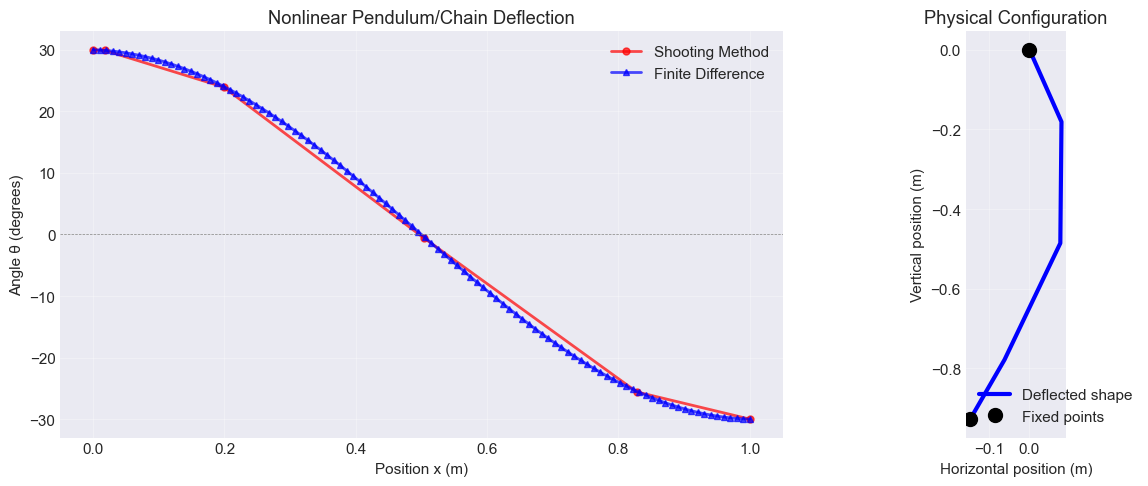

In [22]:
# Plot nonlinear pendulum solution
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# Angle vs position
ax1.plot(x_shoot_nl, np.degrees(theta_shoot), 'ro-', 
         linewidth=2, markersize=5, label='Shooting Method', alpha=0.7)
ax1.plot(x_fd_nl, np.degrees(theta_fd), 'b^-', 
         linewidth=2, markersize=4, label='Finite Difference', alpha=0.7)
ax1.axhline(0, color='gray', linestyle='--', linewidth=0.5)
ax1.set_xlabel('Position x (m)')
ax1.set_ylabel('Angle θ (degrees)')
ax1.set_title('Nonlinear Pendulum/Chain Deflection')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Physical configuration
# Convert angle to Cartesian coordinates
n_points = len(x_shoot_nl)
x_cart = np.zeros(n_points)
y_cart = np.zeros(n_points)

for i in range(1, n_points):
    dx = x_shoot_nl[i] - x_shoot_nl[i-1]
    angle = theta_shoot[i]
    x_cart[i] = x_cart[i-1] + dx * np.sin(angle)
    y_cart[i] = y_cart[i-1] - dx * np.cos(angle)

ax2.plot(x_cart, y_cart, 'b-', linewidth=3, label='Deflected shape')
ax2.plot([x_cart[0]], [y_cart[0]], 'ko', markersize=10, label='Fixed points')
ax2.plot([x_cart[-1]], [y_cart[-1]], 'ko', markersize=10)
ax2.set_xlabel('Horizontal position (m)')
ax2.set_ylabel('Vertical position (m)')
ax2.set_title('Physical Configuration')
ax2.set_aspect('equal')
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()